### Data 586 MiniProject 1 - CNN
### Alex Tamm
### 2020-04-26

### Semantic Segmentation on Satellite Imagery using a U-Net (CNN)


## Overview

I have interspersed discussion with the code blocks but the bulk of the discussion about the model and various issues/discoveries while building/training it are at the end of the document. The general flow is as follows:

#### Data
- About the data
- Load Metadata
- Functions for importing, processing, and saving the imagery files
- Driver code for the above functions
- Functions for importing, processing, and saving the mask (label) files
- Driver code for the above functions
- Functions for file management (moving the processed files to proper folders for import later)

#### Model
- About the model
- Define the model
- Compile the model
- Define Data generator (commented out as performance is unacceptable)
- import training and test data
- Load weights or Train Model

#### Results   
- Examine one location's worth of predicted data in more detail
- Discussion

#### Demo (**This is probably the only code you want to run!**)
- Load the model
- Run a prediction on a test image
- View the results


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import json
#import geojson
import shapely.wkt
import tifffile as tiff
from skimage.transform import resize

from pathlib import Path
import csv
import sys
import shutil

seed = 20200404
np.random.seed = seed
tf.seed = seed

## Data - About the data

Dataset URL: https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data

Dataset consists of imagery of 450 locations (some of which are immediately adjacent to each other but I am ignoring that relationship). Of these 450 locations, 25 of them have labelled polygons associated with them. The remaining 425 locations are a further test set with undisclosed labels for the associated kaggle competition - these are of no importance in building/testing the model.

The imagery for each location is split across 6 files:   
- locationName_A.tif : 8-bands of Shortwave Infared Imagery (1195nm - 2365nm)
- locationName_M.tif : 8-bands of Multispectral Imagery (400nm - 1040nm)
- locationName_P.tif : 1-band of Greyscale Panchromatic Imagery (visibale light but in greyscale)
- locationName.tif : 3-bands of Panchromatic Imagery (visable light - aka Red, Green, Blue channels)

The resolutions (image_height x image_width) differ due to the sensor-types that collect the images:   
- The first image is 134x136
- The second image is 837x848
- The third and fourth image are from the same sensors and are 3348x3391

The training labels (polygons outlining 10 different classes of features) are assumed have been drawn at the precision of the largest image resolution.

## Data - List of Import / Data Prep Steps

Training and Test Data are manipulated in the following ways:

### 1)  Satellite imagery (multi-channel Geotiffs)
    A) All 20 bands of data are imported as seprate images from the 4 associated tif that they are split across.
    B) All 20 bands of data are resized to a specific target resolution
    C) All 20 bands of data are padded with zeros to make them equal sizes (not all bands are the same aspect ratio. So resizing alone isn't enough to make all bands resolution match). 
    D) Rescaled and padded images are combined into an array that is image_heightximage_widthx20 channels.
    E) Padded image array is sliced into evenly sized pieces which are stored in one list for further use.

### 2) Training Labels/Polygons of features in images (from Well Known Text format)
    A) All label polygons are imported from train_wkt_v4.csv and converted to MultiPolygon objects using Shapely
    B) Associated scaling factors for each set of polygons in the wkt file are imported from grid_sizes.csv
    C) Polygons are scaled up to the specific target resolution from part 1B.
    D) Polygons are converted to mask images (i.e. an image_height x image_width x 11_classes sized array with value 0 or 1)
    E) Mask image arrays are padded with 0's to match images in part 1C and then sliced as in part 1E
    F) Mask image arrays are flattened down into a 1 channel image (with pixel values from 0 to 10)

## Data - Import meta data

Start by importing train_wkt_v4.csv to get list of images (other data in the file will be used later). Also split a training and test list for later

In [2]:
polyData = pd.read_csv('data/train_wkt_v4.csv')
polyScales = pd.read_csv('data/grid_sizes.csv')
polyScales.rename(columns={"Unnamed: 0": "ImageId"}, inplace=True)

locationList = polyData.ImageId.unique()
print("All locations with labels:",locationList)

#Using 18/25 locations for training, remaining 7 locations for testing. 0.72/0.28 split)

tr_images = locationList[:18]
te_images = locationList[18:]

#print(polyScales.head(20))
print(tr_images)


All locations with labels: ['6040_2_2' '6120_2_2' '6120_2_0' '6090_2_0' '6040_1_3' '6040_1_0'
 '6100_1_3' '6010_4_2' '6110_4_0' '6140_3_1' '6110_1_2' '6100_2_3'
 '6150_2_3' '6160_2_1' '6140_1_2' '6110_3_1' '6010_4_4' '6170_2_4'
 '6170_4_1' '6170_0_4' '6060_2_3' '6070_2_3' '6010_1_2' '6040_4_4'
 '6100_2_2']
['6040_2_2' '6120_2_2' '6120_2_0' '6090_2_0' '6040_1_3' '6040_1_0'
 '6100_1_3' '6010_4_2' '6110_4_0' '6140_3_1' '6110_1_2' '6100_2_3'
 '6150_2_3' '6160_2_1' '6140_1_2' '6110_3_1' '6010_4_4' '6170_2_4']


## Data - Define Image Processing Functions

In [3]:
def load_imagery(locationName):
    imageList = []
    #first load multiband images
    for entry in ["A","M","P"]:
        tempImage = tiff.imread('data/sixteen_band/{}_{}.tif'.format(locationName,entry))
        if entry == "P": #panchromatic image only has one band. So can't iterate through bands
            imageList.append(tempImage)
        else:
            for band in tempImage:
                imageList.append(band)
        print("loaded {}-{} file".format(locationName,entry))
    #next load 3-band images
    for band in tiff.imread('data/three_band/{}.tif'.format(locationName)):
        imageList.append(band)
    print("loaded {} 3-band file".format(locationName))

    #for n in range(0,len(imageList)):
    #    asArray = np.array(imageList[n])
    #    print("band:",n,"shape:",asArray.shape)
    #    print("Min:",np.amin(asArray))
    #    print("Max:",np.amax(asArray))

    return(imageList)

def scale_imagery(imageSet, targetMaxDim):
    for n in range(0,len(imageSet)):
        origH = int(imageSet[n].shape[0])
        origW = int(imageSet[n].shape[1])
        origRatio = origH/origW
        if origH<origW:
            targetW = targetMaxDim
            targetH = int(round(origRatio*targetW,2))
        elif origH>origW:
            targetH = targetMaxDim
            targetW = int(round(targetH/origRatio,2))
        else: #already square
            targetH = targetMaxDim
            targetW = targetMaxDim
        #print("rescaling bandimage num",n,"from",imageSet[n].shape,"to",(targetH,targetW))
        
        #I found that the default interpolation would add imprecision to the resulting upscaled images
        #INTER_NEAREST seems to give same min/max pixel values for each upscaled image band
        imageSet[n]=cv2.resize(imageSet[n], (targetW, targetH), interpolation=cv2.INTER_NEAREST)
        
        #asArray = np.array(imageSet[n])
        #print("Shape of",n,asArray.shape)
        #print("Max:",np.amax(asArray))
        #print("Min:",np.amin(asArray))
        
        #And pad the array.
        padReq = abs(targetW - targetH)
        #print("Original shape:", imageSet[n].shape)
        imageSet[n] = np.array(imageSet[n])
        imageSet[n] = np.reshape(imageSet[n],newshape=(imageSet[n].shape[0],imageSet[n].shape[1],1))
        if targetH<targetW:
            imageSet[n] = np.pad(imageSet[n],[(0, padReq),(0,0),(0,0)],"constant")
        else:
            imageSet[n] = np.pad(imageSet[n],[(0,0),(0,padReq),(0,0)],"constant")
        #print("After padding with zeros:",imageSet[n].shape)        
        
    imageArray = np.concatenate(imageSet[0:len(imageSet)+1],axis=2)
    return(imageArray)

def slice_and_save(imageArray, fileName,numSplits=4,saveFolder="data/preprocess/"):
    imageSlices = []
    sliceCnt = 0
    for vSlice in np.vsplit(imageArray,numSplits):
        for hSlice in np.hsplit(vSlice,numSplits):
            imageSlices.append(hSlice)
            sliceCnt+=1
            imageName = (saveFolder+"{}_S{}.tif".format(fileName,str(sliceCnt)))
            #Uncomment for verbose debugging of array values
            #for band in range(0,20):
            #    asArray = np.array(hSlice[:,:,band])
            #    print("slice:",sliceCnt,"shape:",asArray.shape)
            #    print("Min:",np.amin(asArray))
            #    print("Max:",np.amax(asArray))
            tiff.imsave(imageName,hSlice,planarconfig="CONTIG")
            #print("saving", imageName)
    print("Total number of sliced images:",len(imageSlices))
    print("Size of each sliced image (H x W x channels):",imageSlices[0].shape)




## Data - Run Image Processing

Change the runDataPrep boolean value below if you do want to run the image processng and mask (label) processing routines

In [4]:
runDataPrep = False

In [5]:
#Define Image Processing Parameters and Run

targetMaxRes = 3360
nsplits = 16

cnt=0

if (runDataPrep):
    for location in locationList:
        print("Begin Processing",location)
        temp = load_imagery(location)                   
        temp = scale_imagery(temp, targetMaxRes)
        slice_and_save(temp,numSplits=nsplits,fileName=location)
        cnt +=1
        print(cnt)
    print(cnt,"locations processed. Should be",cnt*nsplits,"files.")
else:
    print("runDataPrep is set to False. No action taken.")

runDataPrep is set to False. No action taken.


### Create Mask Images (aka labels) from polygons

-iterate through each of the unique 25 locations to
1. create shapely polygons for each class
2. scale the polygons according to grid_sizes.csv
3. convert the polygons to single-chanel images (arrays)
4. combine the polygon images into a single, 1 channel image with pixel values of 0-10 (0=no feature, 1-10=feature classes)
5. save the combined polygon image as locationName_labels.tif


## Define image mask (label) creation functions

In [6]:
#I'd like to use the geojson files as that is a common file format in this domain, but for now I'm using the
# provided train_wkt_v4.csv because it is simpler to import

#Using the dataframes I created way back up in the second code cell
#polyData
#polyScales

def create_polygons(locationName, polyDF):
    selectedPolys = polyDF[(polyDF.ImageId==locationName)]
    #I have already confirmed that all images have exactly 10 classes listed in this file
    polyList = []
    for n in range(1,11):
        polyList.append(shapely.wkt.loads(selectedPolys[selectedPolys.ClassType==n].iloc[0,2]))
    return(polyList)

#Use equations provided in data processing tutorial on kaggle: 
#https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/overview/data-processing-tutorial

def upscale_polygons(locationName, polyList,scaleDF):
    xMax = round(float(scaleDF[scaleDF.ImageId==locationName].Xmax.values[0]),6)
    yMin = round(float(scaleDF[scaleDF.ImageId==locationName].Ymin.values[0]),6)
    tempImage = tiff.imread('data/three_band/{}.tif'.format(locationName))
    #print(tempImage.shape)
    h = tempImage.shape[1]
    w = tempImage.shape[2]
    tempImage=None
    wPrime = w * (w/(w + 1))
    hPrime = h * (h/(h + 1))
    xPrime=wPrime/xMax
    yPrime=hPrime / yMin
    
    #print(xMax,yMin,xPrime,yPrime)
    for n in range(0,len(polyList)):
        polyList[n]=(shapely.affinity.scale(polyList[n], xfact=xPrime, yfact=yPrime, origin=(0, 0, 0)))
    return(polyList)

#Adapted mask function created by https://www.kaggle.com/lopuhin/full-pipeline-demo-poly-pixels-ml-poly
def mask_for_polygons(locationName,polyList):
    tempImage = tiff.imread('data/three_band/{}.tif'.format(locationName))
    target_size = tempImage.shape[1:]
    newList = []
    newList.append(np.zeros(target_size, np.uint8))
    for n in range(0,len(polyList)):
        img_mask = np.zeros(target_size, np.uint8)
        if polyList[n]=="MULTIPOLYGON EMPTY":
            newList.append(img_mask)            
        int_coords = lambda x: np.array(x).round().astype(np.int32)
        exteriors = [int_coords(poly.exterior.coords) for poly in polyList[n]]
        interiors = [int_coords(pi.coords) for poly in polyList[n]
                     for pi in poly.interiors]
        cv2.fillPoly(img_mask, exteriors, 1)
        cv2.fillPoly(img_mask, interiors, 0)
        newList.append(img_mask)
    
    return newList


## Data - Run Mask (Label File) Creation Process

In [7]:
#Drive the mask creation functions
if runDataPrep:
    for location in locationList:
        polys=create_polygons(location,polyData)
        polys=upscale_polygons(location,polys,polyScales)

        polys=mask_for_polygons(location,polys)
        polys=scale_imagery(polys,targetMaxRes)
        print(polys.shape)
        polys = np.argmax(polys,axis=2)
        slice_and_save(imageArray=polys,fileName=(location+"-MASK"), numSplits=nsplits, saveFolder="data/masks/")
        #tiff.imshow(polys, cmap="Paired")
        print(np.max(polys))
else:
    print("runDataPrep is set to False. No action taken.")

runDataPrep is set to False. No action taken.


## Data - Move created files to proper folders (last step)

Move all the images to train and test folders


In [8]:
if runDataPrep:
    
    for location in tr_images:
        image_pile = list(Path("data/preprocess/").glob(location+"*.tif"))
        for file in image_pile:
            shutil.move(str(file), "data/pp_train_image/"+file.name)
    for location in te_images:
        image_pile = list(Path("data/preprocess/").glob(location+"*.tif"))
        for file in image_pile:
            shutil.move(str(file), "data/pp_test_image/"+file.name)
    for location in tr_images:
        print(location)
        image_pile = list(Path("data/masks/").glob(location+"*.tif"))
        for file in image_pile:
            shutil.move(str(file), "data/pp_train_mask/"+file.name)
    for location in te_images:
        print(location)
        image_pile = list(Path("data/masks/").glob(location+"*.tif"))
        for file in image_pile:
            shutil.move(str(file), "data/pp_test_mask/"+file.name)
else:
    print("runDataPrep is set to False. No action taken.")

runDataPrep is set to False. No action taken.


# Model - Define the Model

I created a unet but found that the skip connections (concatenating an encoding layer with a decoding layer) would cause issues with my results. I eventually commented these connections out.

I also used a very small dropout as I was running into issues with the results when training with 15% dropout.

The model also had a tendancy to fall into what I expect is a local minimum where it only outputs class 0, I switched to using 'elu' instead of 'relu' and this seemed to help (where at least the adam optimizer would avoid that behaviour)

I had originally used upsampling layers but upon further research, found that Transpose Convolution Layers could give better results.

In [2]:

n_classes=11 #Includes 0 class which is NO CLASS INFO (i.e. blank area without a polygon)
img_h = 210
img_w = 210
d_out = 0.05
st_filters =32 #starting number of filters

inputs = tf.keras.layers.Input((img_w,img_h,20)) #matrix depth of 20 channels
#base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=inputs, input_shape=(img_w,img_h,3), pooling=None, classes=1000)
#Pad the inputs to work with the pooling/upscaling
padded_inputs = tf.keras.layers.ZeroPadding2D(padding=(3))(inputs)

###############################################
# Start Encoding/Left Side of U-Net
###############################################

#Encoder Block 1
encode1 = tf.keras.layers.Conv2D(st_filters, (3,3), activation='elu', padding='same')(padded_inputs)
encode1 = tf.keras.layers.Dropout(d_out)(encode1)
encode1 = tf.keras.layers.Conv2D(st_filters, (3,3), activation='elu', padding='same')(encode1)
pool1 = tf.keras.layers.MaxPooling2D((2,2))(encode1)

#Encoder Block 2
encode2 = tf.keras.layers.Conv2D(st_filters*2, (3,3), activation='elu', padding='same')(pool1)
encode2 = tf.keras.layers.Dropout(d_out)(encode2)
encode2 = tf.keras.layers.Conv2D(st_filters*2, (3,3), activation='elu', padding='same')(encode2)
pool2 = tf.keras.layers.MaxPooling2D((2,2))(encode2)

#Encoder Block 3
encode3 = tf.keras.layers.Conv2D(st_filters*4, (3,3), activation='elu', padding='same')(pool2)
encode3 = tf.keras.layers.Dropout(d_out)(encode3)
encode3 = tf.keras.layers.Conv2D(st_filters*4, (3,3), activation='elu', padding='same')(encode3)
pool3 = tf.keras.layers.MaxPooling2D((2,2))(encode3)


#################
# Bottom of U
#################

#Bottleneck Block

bneck = tf.keras.layers.Conv2D(st_filters, (3,3), activation='elu', padding='same',name='bneck-in')(pool3)
bneck = tf.keras.layers.Dropout(d_out)(bneck)
bneck = tf.keras.layers.Conv2D(st_filters, (3,3), activation='elu', padding='same', name='bneck-out')(bneck)


###############################################
# Start Decoding/Right Side of U-Net
###############################################

#Decoder Block 1
upb = tf.keras.layers.Conv2DTranspose(st_filters*4,kernel_size=(2,2), strides=(2,2), padding='same')(bneck)
#upb = tf.keras.layers.Concatenate([upb,encode3])
decode1 = tf.keras.layers.Conv2D(st_filters*4, (3,3), activation='elu', padding='same')(upb)
decode1 = tf.keras.layers.Dropout(d_out)(decode1)
decode1 = tf.keras.layers.Conv2D(st_filters*4, (3,3), activation='elu', padding='same')(decode1)



#Decoder Block 2
up1 = tf.keras.layers.Conv2DTranspose(st_filters*2,kernel_size=(2,2), strides=(2,2), padding='same')(decode1)
#up1 = tf.keras.layers.Concatenate([up1,encode2])
decode2 = tf.keras.layers.Conv2D(st_filters*2, (3,3), activation='elu', padding='same')(up1)
decode2 = tf.keras.layers.Dropout(d_out)(decode2)
decode2 = tf.keras.layers.Conv2D(st_filters*2, (3,3), activation='elu', padding='same')(decode2)


#Decoder Block 3
up2 = tf.keras.layers.Conv2DTranspose(st_filters,kernel_size=(2,2), strides=(2,2), padding='same')(decode2)
#up2 = tf.keras.layers.Concatenate([up2,encode1])
decode3 = tf.keras.layers.Conv2D(st_filters, (3,3), activation='elu', padding='same')(up2)
decode3 = tf.keras.layers.Dropout(d_out)(decode3)
decode3 = tf.keras.layers.Conv2D(st_filters, (3,3), activation='elu', padding='same')(decode3)
#up3 = tf.keras.layers.UpSampling2D((2,2))(decode3)

unpadded_results = tf.keras.layers.Cropping2D(cropping=3)(decode3)
decode4 = tf.keras.layers.Conv2D(st_filters, (3,3), activation='elu', padding='same')(unpadded_results)
decode4 = tf.keras.layers.Dropout(d_out)(decode4)
decode4 = tf.keras.layers.Conv2D(st_filters, (3,3), activation='elu', padding='same')(decode4)

outputs = tf.keras.layers.Conv2D(n_classes, (1,1), padding='same', activation="softmax")(decode4)

fullmodel = tf.keras.models.Model(inputs, outputs)

## Model - Compile the model

Tried many different configurations of optimizers and found that setting it to optimizer="adam" would consistently give the best chance of optimizing for something other than predicting every pixel is 0. Even creating a tf.keras.optimizers.Adam() object seems to have different default learning rates and often doesn't work well. Multiple learning rates were tested but tended to either go nowhere or converge towards a solution where all pixels were predicted to be class 0 (the most common class in the imagery).


In [3]:
#fullmodel.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#fullmodel.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fullmodel.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fullmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 210, 210, 20)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 216, 216, 20)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 216, 216, 32)      5792      
_________________________________________________________________
dropout (Dropout)            (None, 216, 216, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496 

## Model - Create a data generator for the inputs

I tried multiple versions of this data generator and finally commented it out and loaded the majority of the dataset into memory instead. I need to work on implementing the recommended methods from Tensorflow (much of the prebuilt image handling doesn't seem to be able to be expanded to pixel-by-pixel classification).

https://www.tensorflow.org/guide/data_performance

In [11]:
# train_path = ""
# def my_image_generator(batch_size, isTrain=True, shuffle=True):
#     if isTrain==True:
#         imgp = Path("data/pp_train_image/")
#         labp = Path("data/pp_train_mask/")
#     elif isTrain==False:
#         imgp = Path("data/pp_test_image/")
#         labp = Path("data/pp_test_mask/")
#     img_list = list(imgp.glob('**/*.tif'))
#     lab_list = list(labp.glob('**/*.tif'))
#     nonshuffle_index=0
#     while True:
#         images = []
#         labels = []
#         if shuffle==True:
#             while len(images) < batch_size:
#                 rnd_selection = np.random.choice(len(img_list),batch_size, replace=False)
#                 for index_val in rnd_selection:
#                     #print("adding",img_list[index_val])
#                     images.append(tiff.imread(str(img_list[index_val])))
#                     labels.append(tiff.imread(str(lab_list[index_val]))) #read as a proper greyscale image
#             #print(images[0].shape,labels[0].shape)
#             yield (np.array(images)/1.0, np.array(labels))
#         else:
#             while len(images) < batch_size and nonshuffle_index < len(img_list):
#                 images.append(tiff.imread(str(img_list[nonshuffle_index])))
#                 labels.append(tiff.imread(str(lab_list[nonshuffle_index])))
#                 if nonshuffle_index == len(img_list)-1:
#                     nonshuffle_index=0
#                 else:
#                     nonshuffle_index += 1
#             yield(np.array(images)/1.0, np.array(labels))


# #Choose batch size and initialize generators
# tr_batch_size = 12
# te_batch_size = 12
# n_train_images = len(list(Path("data/pp_train_image/").glob("**/*.tif")))
# n_test_images = len(list(Path("data/pp_test_image/").glob("**/*.tif")))
# print("Train Data Steps:",n_train_images/tr_batch_size)
# print("Validation Data Steps:",n_test_images/te_batch_size)

# tr_gen = my_image_generator(batch_size=tr_batch_size, isTrain=True,shuffle=False)
# te_gen = my_image_generator(batch_size=te_batch_size, isTrain=False,shuffle=False)

# EPOCHS = 2
# train_steps = 384
# val_steps = 15

# cback_checkpoint = tf.keras.callbacks.ModelCheckpoint("sat_cnn_cp001.h5", verbose=1, save_best_only=True)
# cback_earlystop = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
# cb_list = [cback_checkpoint, cback_earlystop]

# fullmodel.fit_generator(generator=tr_gen, steps_per_epoch=train_steps, verbose=1, 
#                         shuffle=False, epochs=EPOCHS,validation_data=te_gen, 
#                         validation_steps=val_steps)


## Model - Load Weights

In [4]:
fullmodel.load_weights("models/sat_cnn003_weights.h5")

## Model - Get list of all training&test files

In [13]:
# Get list of all files and print some statistics

tr_imgp = Path("data/pp_train_image/")
tr_labp = Path("data/pp_train_mask/")
te_imgp = Path("data/pp_test_image/")
te_labp = Path("data/pp_test_mask/")
tr_img_list = list(tr_imgp.glob('**/*.tif'))
tr_lab_list = list(tr_labp.glob('**/*.tif'))
te_img_list = list(te_imgp.glob('**/*.tif'))
te_lab_list = list(te_labp.glob('**/*.tif'))
print("Number of Training Images , Training Labels:", len(tr_img_list), len(tr_img_list))
print("Number of Test/Validation Images , Test/Validation Labels:", len(te_img_list), len(te_img_list))

Number of Training Images , Training Labels: 4608 4608
Number of Test/Validation Images , Test/Validation Labels: 1792 1792


## Model - Load all training data

**Warning** This requires ~10GB of memory

In [ ]:
#Load all training data (This takes ~7.5GB for the images and 1.5GB for the labels)
train_images=[]
train_labels=[]
for n in range(0,len(tr_img_list)):
    train_images.append(tiff.imread(str(tr_img_list[n])))
    train_labels.append(tiff.imread(str(tr_lab_list[n])))
train_images = np.array(train_images)
train_labels= np.array(train_labels)

#train_labels=np.reshape(train_labels,(500,210,210,1))
print(train_images.shape)
print(train_labels.shape)

#for n in range(0,len(train_labels),10):
#    print(np.amin(train_labels[n]),np.mean(train_labels[n]),np.amax(train_labels[n]))

## Model - Load all test data

**Warning** This requires ~4GB of memory

In [27]:
test_images=[]
test_labels=[]
for n in range(0,len(te_img_list)):
    test_images.append(tiff.imread(str(te_img_list[n])))
    test_labels.append(tiff.imread(str(te_lab_list[n])))
test_images = np.array(test_images)
test_labels= np.array(test_labels)
print(test_images.shape)
print(test_labels.shape)

(1792, 210, 210, 20)
(1792, 210, 210)


## Model - Train the Model

In [30]:
cback_checkpoint = tf.keras.callbacks.ModelCheckpoint("sat_cnn_cp003.h5", verbose=0, save_best_only=True)
cback_earlystop = tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss')
cb_list = [cback_checkpoint, cback_earlystop]

epochs_val = 10

fullmodel.fit(x=train_images,y=train_labels, verbose=1, epochs=epochs_val, 
              batch_size=12,shuffle=True, callbacks=cb_list,validation_data=(test_images,test_labels))

Train on 4608 samples, validate on 1792 samples
Epoch 1/10
4608/4608 [==============================] - 84s 18ms/sample - loss: 0.3593 - accuracy: 0.8674 - val_loss: 1.3038 - val_accuracy: 0.7388
Epoch 2/10
4608/4608 [==============================] - 78s 17ms/sample - loss: 0.3320 - accuracy: 0.8767 - val_loss: 1.2696 - val_accuracy: 0.7151
Epoch 3/10
4608/4608 [==============================] - 79s 17ms/sample - loss: 0.3404 - accuracy: 0.8739 - val_loss: 1.3290 - val_accuracy: 0.7070
Epoch 4/10
4608/4608 [==============================] - 76s 16ms/sample - loss: 0.3298 - accuracy: 0.8774 - val_loss: 1.3107 - val_accuracy: 0.7057
Epoch 5/10
4608/4608 [==============================] - 81s 18ms/sample - loss: 0.3457 - accuracy: 0.8723 - val_loss: 1.0604 - val_accuracy: 0.7209
Epoch 6/10
4608/4608 [==============================] - 76s 16ms/sample - loss: 0.3503 - accuracy: 0.8709 - val_loss: 1.3224 - val_accuracy: 0.7227
Epoch 7/10
4608/4608 [==============================] - 75s 16ms

In [9]:
#fullmodel.save_weights("models/sat_cnn003_weights.h5")
#tf.keras.models.save_model(fullmodel,"saved_model")


INFO:tensorflow:Assets written to: saved_model\assets


## Results - Validate Model

In [115]:
loc_name = "6010_1_2"
test_image_list=[]
test_label_list=[]

total_class = [0,0,0,0,0,0,0,0,0,0,0]
conf_matrix = np.zeros((11,11))


#Build list of all 256 images for desired location 6010_1_2
for n in range(1,257):
    test_image_list.append(np.array(tiff.imread("data/pp_test_image/"+loc_name+"_S"+str(n)+".tif")))
    test_label_list.append(np.array(tiff.imread("data/pp_test_mask/"+loc_name+"-MASK_S"+str(n)+".tif")))

test_image_list = np.array(test_image_list)
test_label_list = np.array(test_label_list)

results = fullmodel.predict(test_image_list)

processed_results = []
for n in range (0, results.shape[0]):
    temp = np.argmax(results[n],axis=2)
    processed_results.append(temp)
    truth_flat = np.reshape(np.array(test_label_list[n]),(210*210,1))
    pred_flat = np.reshape(temp,(210*210,1))
    for n in range(0,len(truth_flat)):
        truth = int(truth_flat[n])
        pred = int(pred_flat[n])
        total_class[truth] += 1
        conf_matrix[pred,truth] +=1

## Results - Display a Confusion matrix for the location tested

(Truth=columns, predictions=rows) 

Row and Column Labels = class number

In [116]:
print("Location:",loc_name)
print("total pixels of each class 0-10:",total_class)
print("Correct classification %:",sum(np.diag(conf_matrix))/np.sum(conf_matrix)*100)

conf_df = pd.DataFrame(conf_matrix, dtype=int)
conf_df

Location: 6010_1_2
total pixels of each class 0-10: [10559694, 0, 8339, 0, 163867, 557700, 0, 0, 0, 0, 0]
Correct classification %: 83.21725304705215


,0,1,2,3,4,5,6,7,8,9,10
0,8976677,0,4089,0,146717,136602,0,0,0,0,0
1,75,0,90,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,1207,0,0,0,1202,0,0,0,0,0,0
4,16671,0,27,0,6004,72,0,0,0,0,0
5,974175,0,4128,0,3625,412214,0,0,0,0,0
6,590760,0,1,0,6319,8773,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0
8,128,0,4,0,0,39,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0


## Results - Display Image and Actual vs Predicted classes

Displaying the three images for 240x240 slice from the top left of the location (to show detail) and then showing the three images for the entire location

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x1905c0a2448>)

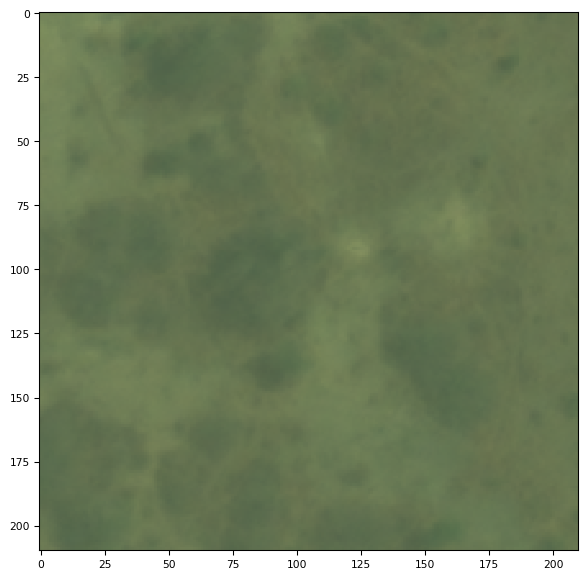

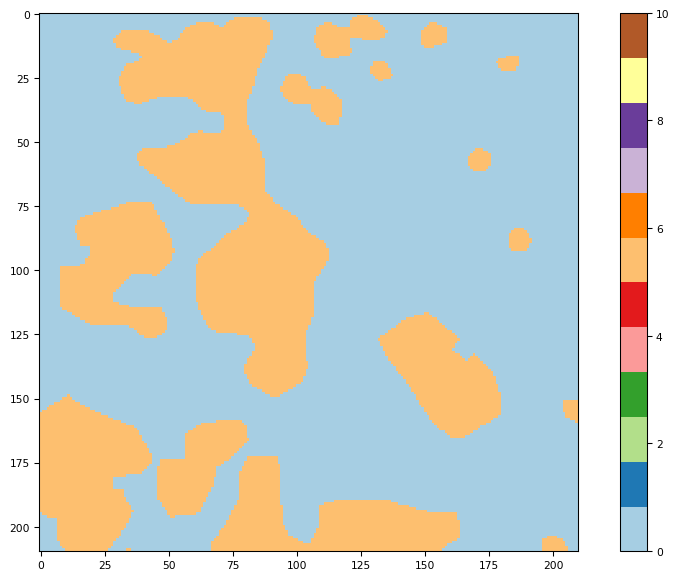

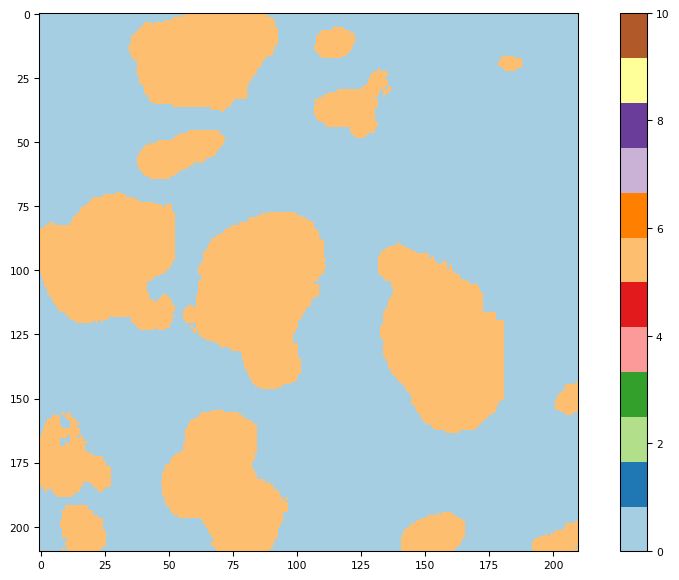

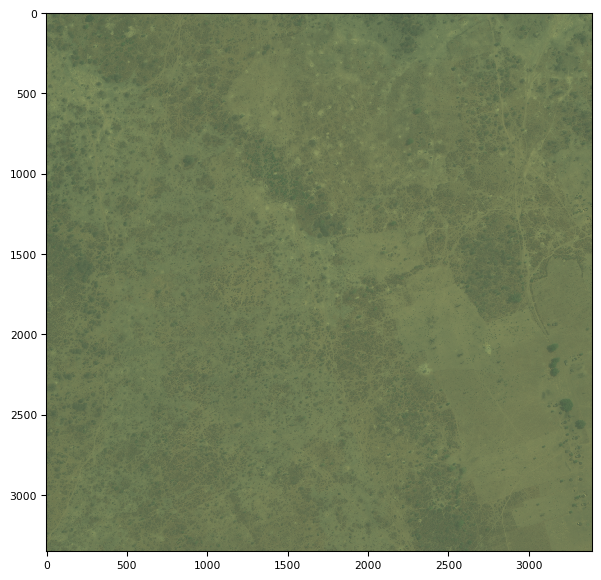

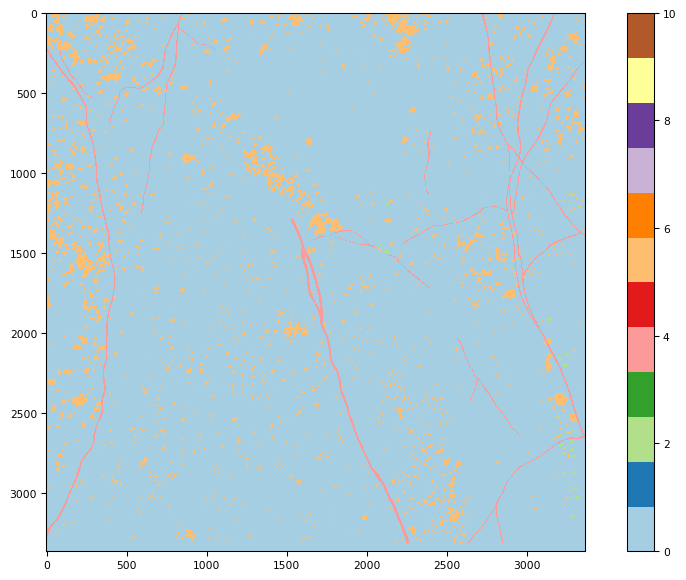

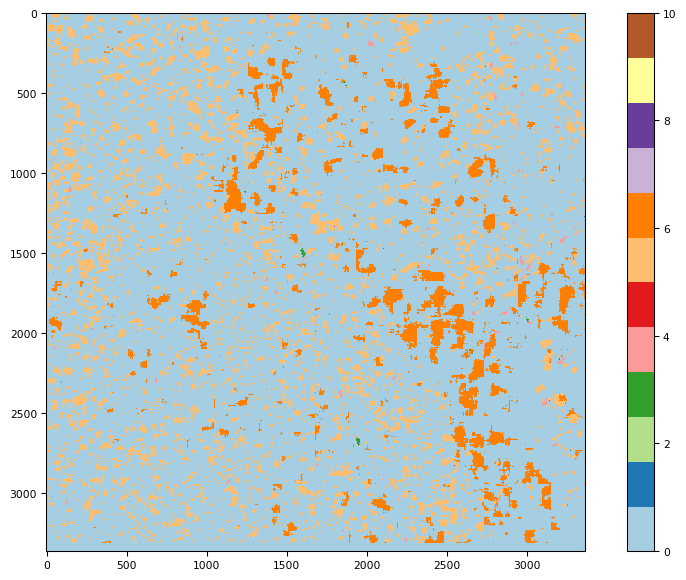

In [144]:
#Rebuild large image for entire location
def rebuild_image(img_dim,img_cnt,img_list):
    big_array = np.zeros((img_dim*img_cnt,img_dim*img_cnt))
    s_count=0
    for r in range(0,img_dim*img_cnt,img_dim):
        #print("now filling row", r)
        for c in range(0,img_dim*img_cnt,img_dim):
            section = img_list[s_count]
            big_array[r:r+img_dim,c:c+img_dim] = section
            s_count +=1
    return big_array

img_dim = 210
img_cnt = 16

big_label = rebuild_image(img_dim,img_cnt,test_label_list)
big_result = rebuild_image(img_dim,img_cnt,processed_results)

#Display one single section (top left corner of location)
tiff.imshow(test_image_list[0][:,:,17:20])
tiff.imshow(test_label_list[0], cmap="Paired",vmin=0, vmax=10)
tiff.imshow(processed_results[0], cmap="Paired", vmin=0, vmax=10)

#Display entire location
tiff.imshow(tiff.imread("data/three_band/"+loc_name+".tif"))
tiff.imshow(big_label, cmap="Paired", vmin=0, vmax=10)
tiff.imshow(big_result,cmap="Paired",vmin=0, vmax=10)



## Results - Discussion

While overall, the classification accuracy is above 80% for the image chosen (and ~70-73% validation accuracy during training), most of these properly classified pixels are the 0-class. This seems to be due to unbalanced classes (most pixels in the training/test data are in truth 0-class). This is an issue that will have to be addressed to get better results. This is also the reason, I suspect, that things such as roads aren't being detected very well. The model is seeing far more pixels of class 0 than of class 4. 

Working with large, multi-channel images requires a model with many trainable parameters. This, however, seems to cause issues for a lot of the available optimizers (at least as I have configured my model). I found that when I tried to make more complex models (larger number of filters, more layers, adding skip connections) that resulted in between 1.5 to 2.0 million trainable parameters then I could not manage to train the model to do anything other than yield 0 class for most pixels. I think the influence of unbalanced classes is the major cause, creating a strong local minimum that the optimizer heads towards. I also think it is possible that with this higher number of trainable parameters, other weaknesses may be exposed. Normalizing all of the inputs may help (currently each band has its own min/max range of integer values). 

Things I would like to investigate/implement:
- Proper input pipeline using some of Tensor Flow's built in functions and datatypes to take advantage of splitting    work between multiple cores (without just loading the whole dataset in memory)   
- Normalize all the channels of the input images to see if this improves performance/trainability    
- Add in Tensorboard to visualize training performance   
- Increase complexity of model and leave to train in CPU mode to see if results are different than in GPU mode   
- Look into Dilated CNN's   
- Slice the images so there is overlap, if there are features that span two image slices this should improve the detection of those features.

**Big takeaways**   
- The keras/Tensorflow ecosystem is constantly changing and what might have been considered best practice a year ago may have changed. This makes it worth double checking the tensorflow docs and scanning through multiple sources on a topic before trying to implement it.
- While Unets are pretty easy to implement, everything gets far more complicated with unbalanced classes and large inputs.
- Satellite imagery is NOT like dash-cam photograhs (data-set I used to build a proof-of-concept unet before writing this code). Objects are not as clearcut as say a sidewalk and a car and clear feature detection seems to just be harder, even with 20 bands of information. I am starting to see why automated classification isn't something that is just included with GIS software by default - there isn't a one-size-fits-all solution and if there were, odds are the company that built it will want to recoup the costs by selling it as an addon!

## Demo

Run all the cells below here after downloading the example image and making sure it is in the same directory structure as the github repo.

In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff

loaded_model = tf.keras.models.load_model("saved_model")

Displaying inputs and results for the two examples passed into the model. Order of display is:
Imagery (input)
 Actual Pixel Classes
 Predicted Pixel Classes
Confusion Matrix: Rows=Predicted Class, Columns=Actual Class


,0,1,2,3,4,5,6,7,8,9,10
0,53271,0,0,0,1797,5807,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,6605,0,0,0,7,19634,0,0,0,0,0
6,1073,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,5,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0


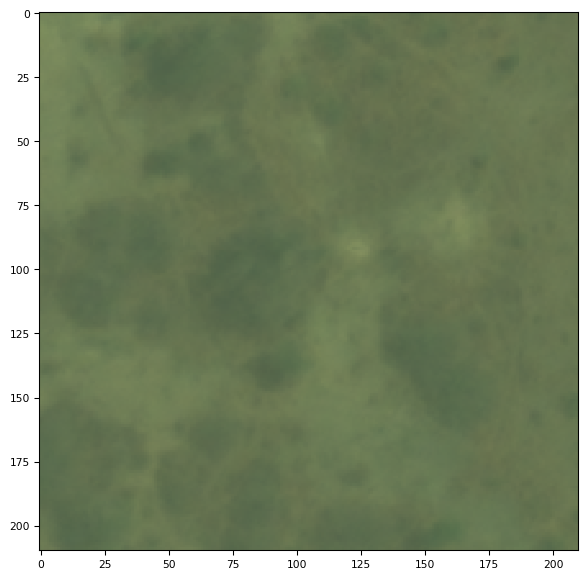

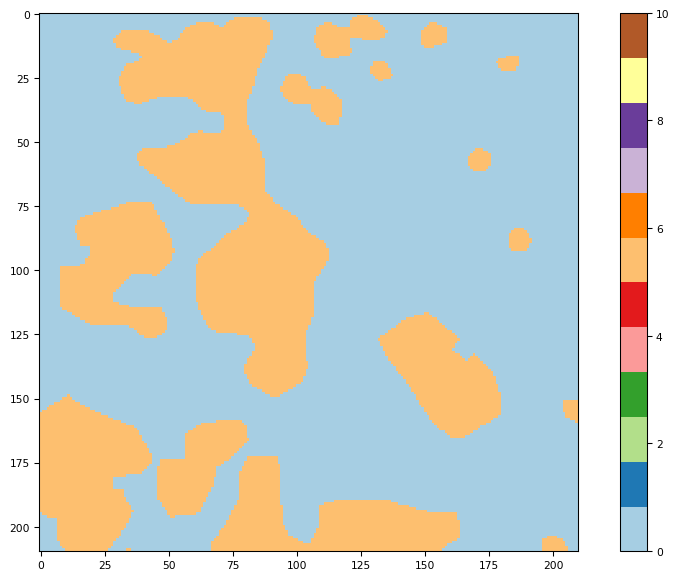

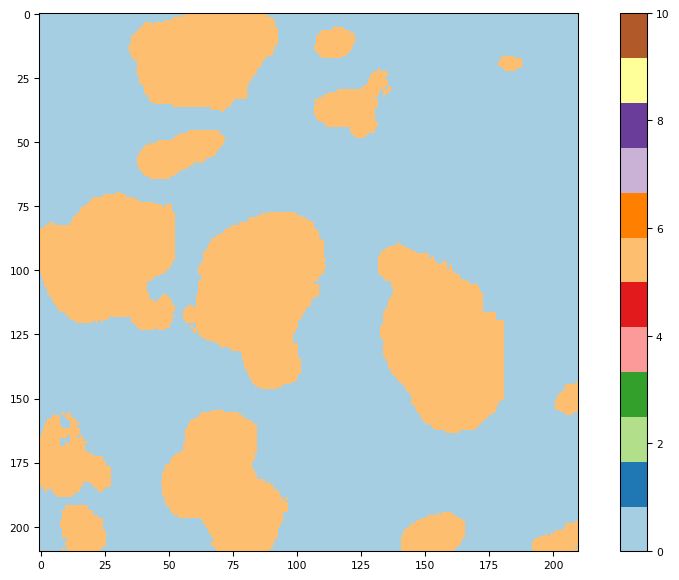

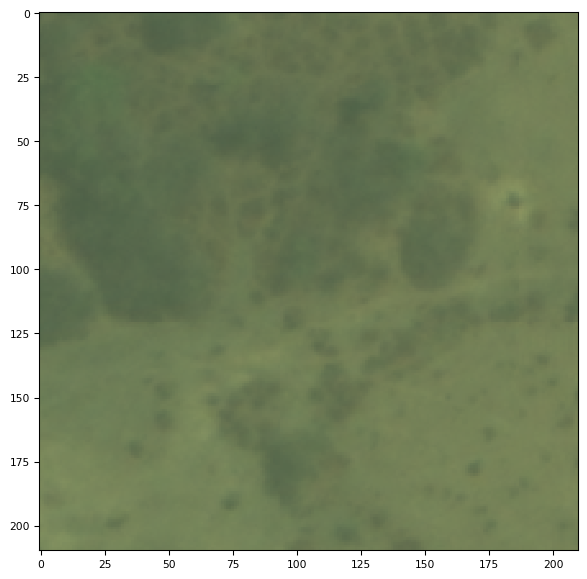

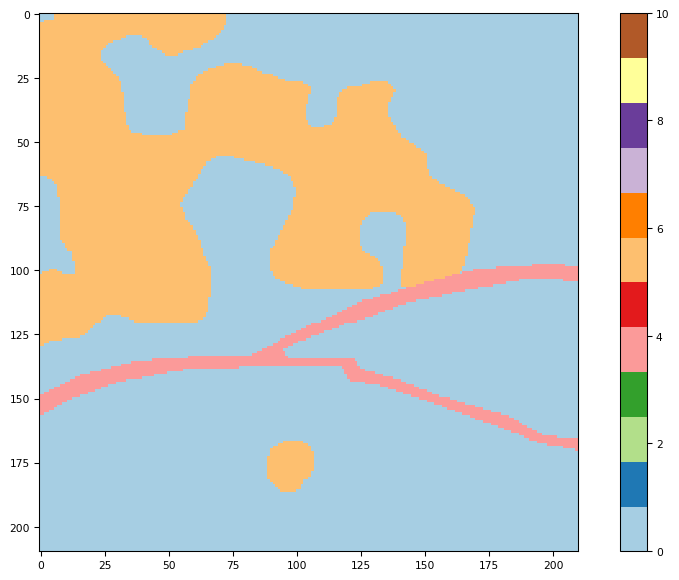

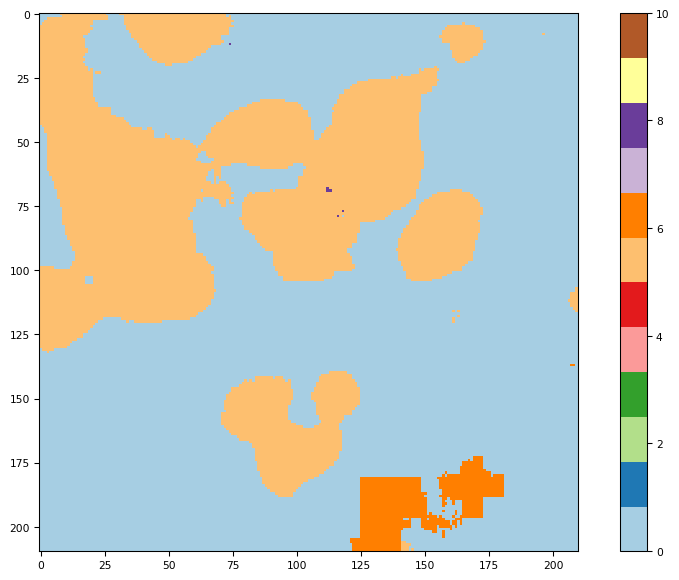

In [24]:
test_image_list = [tiff.imread("data/pp_test_image/6010_1_2_S1.tif"),tiff.imread("data/pp_test_image/6010_1_2_S105.tif")]
test_label_list = [tiff.imread("data/pp_test_mask/6010_1_2-MASK_S1.tif"),tiff.imread("data/pp_test_mask/6010_1_2-MASK_S105.tif")]

results = loaded_model.predict(np.array(test_image_list))

total_class = [0,0,0,0,0,0,0,0,0,0,0]
conf_matrix = np.zeros((11,11))
processed_results = []
for n in range (0, results.shape[0]):
    temp = np.argmax(results[n],axis=2)
    processed_results.append(temp)
    truth_flat = np.reshape(np.array(test_label_list[n]),(210*210,1))
    pred_flat = np.reshape(temp,(210*210,1))
    for n in range(0,len(truth_flat)):
        truth = int(truth_flat[n])
        pred = int(pred_flat[n])
        total_class[truth] += 1
        conf_matrix[pred,truth] +=1
print("Displaying inputs and results for the two examples passed into the model. Order of display is:")
print("Imagery (input)\n Actual Pixel Classes\n Predicted Pixel Classes")
for n in range(0,2):    
    tiff.imshow(test_image_list[n][:,:,17:20])
    tiff.imshow(test_label_list[n], cmap="Paired", vmin=0,vmax=10)
    tiff.imshow(processed_results[n], cmap="Paired", vmin=0,vmax=10)
print("Confusion Matrix: Rows=Predicted Class, Columns=Actual Class")
pd.DataFrame(conf_matrix,dtype=int)